In [6]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import eofs
import xrft
#from cdo import Cdo
#cdo = Cdo(tempdir='network/aopp/chaos/pred/leach/.cdo_temp_files')
# uncomment the below if you want to/ clean up the temporary directory
# cdo.cleanTempDir()
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import regionmask
import xskillscore as xs
import pandas as pd
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
import palettable
from shapely.geometry.polygon import LinearRing
import copy
import shutil
import gzip
import warnings

#sys.path.append('/home/l/luol/Downloads/')
#import ScientificColourMaps6 as SCM6

from IPython.display import display, clear_output

## get FaIR
from fair import *

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

## matplotlib rcParams
## IF you want to use thesis style

import requests
from io import StringIO, BytesIO

req = requests.get('https://raw.githubusercontent.com/njleach/Thesis/main/ancil/figure-style.mplstyle')
'''
with open("/home/l/leach/thesis.mplstyle", "w") as text_file:
    text_file.write(req.content.decode())
    
plt.style.use("/home/l/leach/thesis.mplstyle")
textwidth = matplotlib.rcParams['figure.figsize'][0]

%matplotlib inline
'''

'\nwith open("/home/l/leach/thesis.mplstyle", "w") as text_file:\n    text_file.write(req.content.decode())\n    \nplt.style.use("/home/l/leach/thesis.mplstyle")\ntextwidth = matplotlib.rcParams[\'figure.figsize\'][0]\n\n%matplotlib inline\n'

In [7]:
import dask
from dask.distributed import Client, LocalCluster

def setUpCluster(
    n_workers: int, low_workers: int, high_workers: int, memory_limit: int
):
    dask.config.set({"temporary_directory": "/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/tmp/dask-scratch-space-danqing"})
    dask.config.set({"array.slicing.split_large_chunks": True})
    dask.config.set({"distributed.worker.memory.spill": 0.8})
    dask.config.set({"distributed.worker.use_file_locking": True})
    # DASK CLUSTER SET UP
    cluster = LocalCluster(
        n_workers=n_workers,
        dashboard_address="localhost:14286",
        memory_limit=f"{memory_limit} GiB",
        threads_per_worker=2,
    )
    cluster.adapt(minimum=low_workers, maximum=high_workers)

    print(f"dashboard : {cluster.dashboard_link}")
    client = Client(cluster)

    return cluster, client

In [8]:
## set up dask
cluster, client = setUpCluster(n_workers= 6, low_workers= 4, high_workers=10, memory_limit=6)

/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.79s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


dashboard : http://127.0.0.1:14286/status


In [9]:

def import_medr_tracks_TE(fpath):
    
    df = pd.read_csv(fpath,skipinitialspace=True)
    
    expdict = {'1':'ENS','b2nn':'pi','b2nq':'pi','b2ns':'pi','b2no':'incr','b2nr':'incr','b2nt':'incr'}
    
    fname = fpath.split('/')[-1]
    _,expid,inidate,mem = fname.split('_')
    
    df['expid'] = expid
    df['experiment'] = expdict[expid]
    df['inidate'] = pd.to_datetime(inidate)
    df['number'] = int(mem)
    
    return df


In [10]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(import_medr_tracks_TE, glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==4')

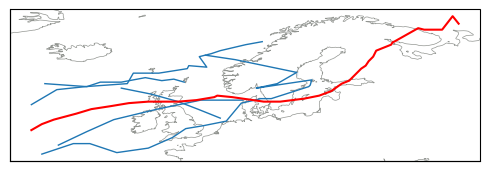

In [11]:


g=sn.relplot(data=ifs_tracks.query('inidate=="2022-02-10" & experiment=="ENS" & number==2'),x='lon',y='lat',size='track_id',sort=False,sizes=(1,1),kind='line',legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())))

sn.lineplot(data=eunice_track,x='lon',y='lat',legend=False,color='r')

g.axes[0,0].coastlines(color='xkcd:grey',lw=0.5)



In [12]:


ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min, day=np.size, lon = lambda x: x.iloc[0], lat = lambda x: x.iloc[0], msl = min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min, day=np.size, lon = lambda x: x.iloc[0], lat = lambda x: x.iloc[0], msl = min)).iloc[0]

eunice_filter



date    2022-02-15 06:00:00
day                      42
lon                   -27.0
lat                    52.0
msl                95954.33
Name: (4, 2022-01-01 00:00:00, era5, 0), dtype: object

In [13]:
## starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
## starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
## depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]


In [14]:
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

ifs_eunice_list.head()



,track_id,inidate,experiment,number,year,month,day,hour,i,j,lon,lat,msl,vo,expid,date
0,0,2022-02-14,ENS,16,2022,2,15,6,0,86,-27.00,52.00,99070.44,0.000121,1,2022-02-15 06:00:00
1,0,2022-02-14,ENS,16,2022,2,15,9,3,82,-26.25,53.00,98661.08,0.000183,1,2022-02-15 09:00:00
2,0,2022-02-14,ENS,16,2022,2,15,12,14,79,-23.50,53.75,98429.77,0.000234,1,2022-02-15 12:00:00
3,0,2022-02-14,ENS,16,2022,2,15,15,21,76,-21.75,54.50,98170.72,0.000234,1,2022-02-15 15:00:00
4,0,2022-02-14,ENS,16,2022,2,15,21,0,71,-27.00,55.75,97449.38,0.000102,1,2022-02-15 21:00:00


In [15]:
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

multi_track_members



,,,year
inidate,experiment,number,


In [16]:
def eunice_dist(df):
    
    eunice_lons = eunice_track.lon.values
    eunice_lats = eunice_track.lat.values
    
    track_lons = df.lon.values
    track_lats = df.lat.values
    
    minsize = min(eunice_lons.size,track_lons.size)
    
    return np.sqrt((track_lons[:minsize]-eunice_lons[:minsize])**2+(track_lats[:minsize]-eunice_lats[:minsize])**2).sum()


In [17]:
for idx in multi_track_members.index:
    
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(eunice_dist)
    
    num_reject = track_dists.idxmax()
    
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)



2023-08-17 15:49:43,205 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:41175'.
2023-08-17 15:49:43,220 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:41175'. Shutting down.
2023-08-17 15:49:43,222 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:46383'.
2023-08-17 15:49:43,225 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:46383'. Shutting down.


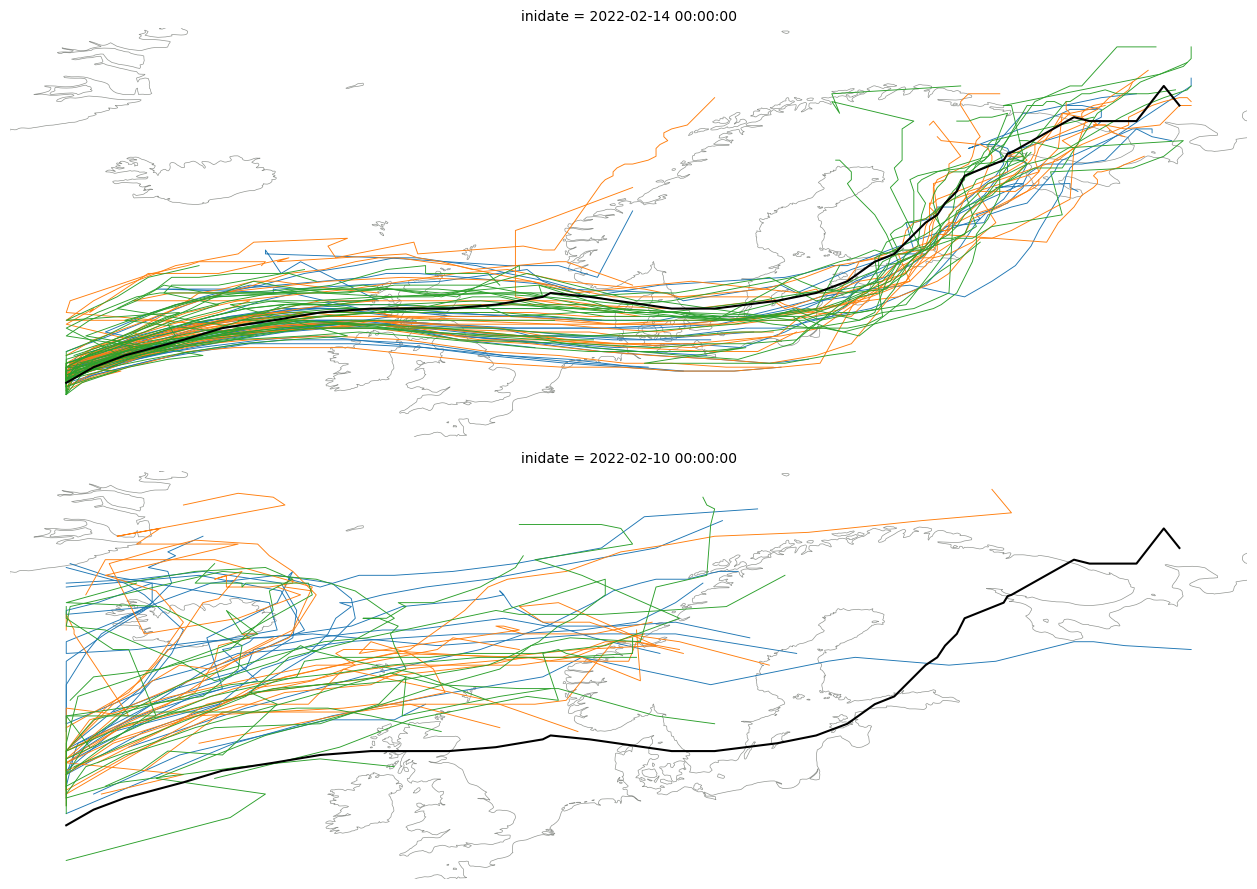

In [18]:
g=sn.relplot(data=ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])],x='lon',y='lat',row='inidate',hue='experiment',hue_order=['pi','ENS','incr'],size='number',sort=False,estimator=None,sizes=(0.66,0.66),kind='line',height=4.5,legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())),aspect=3)

[sn.lineplot(data=eunice_track,x='lon',y='lat',legend=False,color='k',ax=a) for a in g.axes.flatten()]
[a.coastlines(color='xkcd:grey',lw=0.5) for a in g.axes.flatten()]
[a.axis('off') for a in g.axes.flatten()];

In [19]:
import stormeunice as eun

In [20]:
'''def preproc_to_stormframe(ds):
    
    ds = ds.copy()
    
    if not 'number' in ds.coords:
        ds = ds.expand_dims({'number':[0]})
        
    fpath = ds.encoding['source']
    
    exp = fpath.split('/')[-5]
    inidate = fpath.split('/')[-1].split('_')[-1].split('.')[0]
    
    ds_tracks = ifs_eunice_list.query('experiment=="{}" & inidate=="{}"'.format(exp,inidate))

    LG_fields = []

    for num in set(ds.number.values).intersection(ds_tracks.number.unique()):

        mem_track = ds_tracks.loc[ds_tracks.number==num]
        mem_fields = ds.sel(number=num)
        time_intersection = sorted(list(set(mem_fields.time.values).intersection(mem_track.date.values)))
        
        resample_freq = 3 ## resampling frequency in hours
        if inidate == '2022-02-10':
            resample_freq = 6
        
        ## get start / end times for properly calculating the maximum fields (taking into account the different preproc times in IFS)
        time_start = time_intersection[0]-pd.Timedelta('{}h 59m'.format(resample_freq-1))
        time_end = time_intersection[-1]

        ## get the instantaneous fields + wind speeds
        mem_fields_out = mem_fields.get(['sst','u10','v10','msl','u100','v100','tcwv']).sel(time = time_intersection)
        mem_fields_out['ws10'] = np.sqrt(mem_fields_out.u10**2+mem_fields_out.v10**2)
        mem_fields_out['ws100'] = np.sqrt(mem_fields_out.u100**2+mem_fields_out.v100**2)
        
        ## get the maximum fields, taking into account the different preproc times
        mxtpr_field_out = mem_fields.mxtpr.sel(time=slice(time_start,time_end)).resample(time='{}h'.format(resample_freq),label='right',closed='right',base=0).max()
        mem_fields_out['mxtpr'] = mxtpr_field_out

        ## add in the mslp centroid lon/lats for Lagrangian analysis 
        mem_track_out = mem_track.loc[mem_track.date.isin(time_intersection)]
        mem_fields_out['centroid_lon'] = ('time',(mem_track_out.lon*4).round()/4)
        mem_fields_out['centroid_lat'] = ('time',(mem_track_out.lat*4).round()/4)

        ## convert to storm frame fields
        mem_fields_out = mem_fields_out.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)
        mem_fields_out = mem_fields_out.assign(datetime=mem_fields_out.time).drop('time').rename(time='timestep')
        
        ## compute the time of peak vorticity (include moving average to smooth) for storm composites
        peak_vo = mem_track.rolling(3,center=True).mean().vo.idxmax()
        peak_vo_datetime = mem_track.date.loc[peak_vo]
        peak_vo_relative_time = (mem_fields_out.datetime.squeeze().to_pandas() - peak_vo_datetime).dt.total_seconds().values/(3600*24)

        ## set the storm frame fields timestep relative to peak vorticity time
        mem_fields_out = mem_fields_out.assign_coords(timestep=peak_vo_relative_time)

        LG_fields += [mem_fields_out]
        
    LG_fields = xr.concat(LG_fields,'number')
    
    LG_fields = LG_fields.expand_dims(dict(inidate=[pd.to_datetime(inidate)],experiment=[exp]))
    
    return LG_fields
    '''

'def preproc_to_stormframe(ds):\n    \n    ds = ds.copy()\n    \n    if not \'number\' in ds.coords:\n        ds = ds.expand_dims({\'number\':[0]})\n        \n    fpath = ds.encoding[\'source\']\n    \n    exp = fpath.split(\'/\')[-5]\n    inidate = fpath.split(\'/\')[-1].split(\'_\')[-1].split(\'.\')[0]\n    \n    ds_tracks = ifs_eunice_list.query(\'experiment=="{}" & inidate=="{}"\'.format(exp,inidate))\n\n    LG_fields = []\n\n    for num in set(ds.number.values).intersection(ds_tracks.number.unique()):\n\n        mem_track = ds_tracks.loc[ds_tracks.number==num]\n        mem_fields = ds.sel(number=num)\n        time_intersection = sorted(list(set(mem_fields.time.values).intersection(mem_track.date.values)))\n        \n        resample_freq = 3 ## resampling frequency in hours\n        if inidate == \'2022-02-10\':\n            resample_freq = 6\n        \n        ## get start / end times for properly calculating the maximum fields (taking into account the different preproc times in 

In [21]:
'''ens_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)
'''

"ens_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)\npi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)\nincr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)\n"

In [22]:

# Import field data, Lagrangian fram
curr_storms = xr.open_mfdataset([x for x in glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc') if not '02-16' in x],
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset([x for x in glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc') if not '02-16' in x],
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset([x for x in glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc') if not '02-16' in x],
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

2023-08-17 15:49:46,181 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2023-08-17 15:49:46,183 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/stormeunice/lagrangian.py:268: FutureWarning: Following pandas, the `base` parameter to resample will be deprecated in a future version of xarray.  Switch to using `origin` or `offset` instead.
  mxtpr_field_out = selected_times.resample(time='{}h'.format(resample_freq), label='right', closed='right', base=0).max()
/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/stormeunice/lagrangian.py:268: FutureWarning: Following pandas, the `base` parameter to resample will be deprecated in a future version of xarray.  Switch to using `origin` or `offset` instead.
  mxtpr_field_out = selected_times.resample(time='{}h'.format(resample_freq), la

DataError: Cannot aggregate non-numeric type: datetime64[ns]

2023-08-17 15:49:53,190 - distributed.worker - WARNING - Compute Failed
Key:       lambda-728ea1bc-152e-47b4-b4ba-a1dd9b89d40f
Function:  lambda
args:      (<xarray.Dataset>
Dimensions:    (longitude: 289, latitude: 163, number: 50, time: 109)
Coordinates:
  * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0
  * number     (number) int32 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 2022-02-14 ... 2022-02-20
Data variables: (12/14)
    sst        (time, number, latitude, longitude) float32 dask.array<chunksize=(109, 50, 163, 289), meta=np.ndarray>
    fg10       (time, number, latitude, longitude) float32 dask.array<chunksize=(109, 50, 163, 289), meta=np.ndarray>
    tcw        (time, number, latitude, longitude) float32 dask.array<chunksize=(109, 50, 163, 289), meta=np.ndarray>
    tcwv       (time, number, latitude, longitude) float32 dask.ar

2023-08-16 14:26:54,736 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:44441'.
2023-08-16 14:26:54,738 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:44441'. Shutting down.
2023-08-16 14:26:54,804 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:33487'.
2023-08-16 14:26:54,807 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:33487'. Shutting down.
2023-08-16 14:26:54,811 - tornado.application - ERROR - Exception in callback functools.partial(<function TCPServer._handle_connection.<locals>.<lambda> at 0x7f807fb47550>, <Task finished name='Task-53717' coro=<BaseTCPListener._handle_stream() done, defined at /home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/distributed/comm/tcp.py:599> exception=ValueError('invalid operation on non-started TCPListener')>)
Traceback (most recent call last):
 

Text(29.597222222222214, 0.5, 'lat from storm centre')

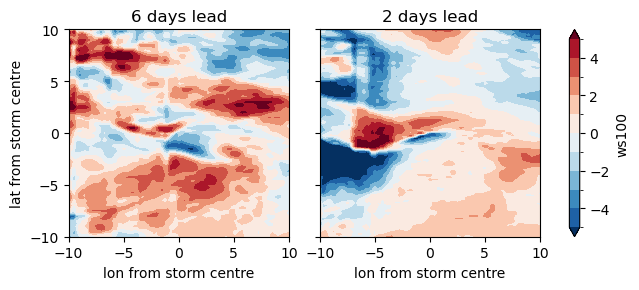

In [ ]:
cplot = (incr_storms.ws100.sel(timestep=0).mean('number').squeeze() - pi_storms.ws100.sel(timestep=0).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

cplot.axes[0,0].set_title('6 days lead')
cplot.axes[0,1].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

In [ ]:
timestep=[1,2,3,4]
cplot = (incr_storms.ws100.sel(inidate='2022-02-10',experiment='incr',timestep=[-2,-1,0,1,2]).mean('number').squeeze() - pi_storms.ws100.sel(inidate='2022-02-10',experiment='pi',timestep=[-3,-2,-1,0,1,2,3]).mean('number').squeeze()).sortby('timestep').plot.contourf(col='timestep',levels=np.linspace(-10,10,21))
'''
cplot.axes[0,0].set_title('6 days lead')
cplot.axes[0,1].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')'''

KeyError: "not all values found in index 'timestep'"

Okay, Now i know why Shirin and Nick only use timestep=0

In [ ]:

incr_storms.sel(inidate='2022-02-10').sel(experiment='incr').mean('number')

<xarray.Dataset>
Dimensions:       (storm_lon: 81, storm_lat: 81, timestep: 48)
Coordinates:
  * storm_lon     (storm_lon) float64 -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
  * storm_lat     (storm_lat) float64 -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
  * timestep      (timestep) float64 -1.375 -1.25 -1.125 -1.0 ... 4.25 4.375 4.5
    experiment    <U4 'incr'
    inidate       datetime64[ns] 2022-02-10
Data variables: (12/13)
    sst           (timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    u10           (timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    v10           (timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    msl           (timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    u100          (timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    v100          (timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    ...            ...
    tcwv          (timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    ws10          (timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    ws100         (timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    mxtpr         (timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 81, 81), meta=np.ndarray>
    centroid_lon  (timestep) float64 nan nan nan -27.0 nan ... nan 1.125 nan nan
    centroid_lat  (timestep) float64 nan nan nan 49.75 nan ... nan 64.62 nan nan

In [ ]:
incr_storms.ws100.



<xarray.DataArray 'number' (number: 40)>
array([ 2,  3,  4,  5,  6,  7,  9, 10, 13, 14, 15, 17, 19, 20, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45,
       46, 47, 48, 50], dtype=int32)
Coordinates:
  * number   (number) int32 2 3 4 5 6 7 9 10 13 ... 40 41 43 44 45 46 47 48 50
Attributes:
    long_name:  ensemble_member

Text(29.597222222222214, 0.5, 'lat from storm centre')

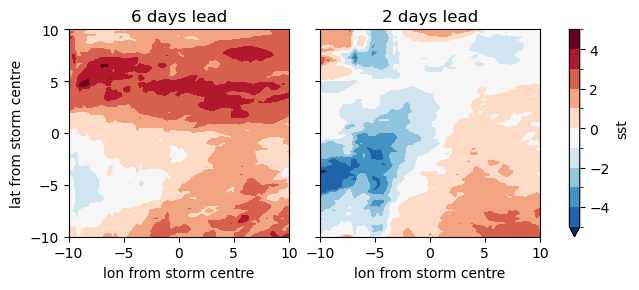

2023-08-15 11:22:38,256 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2023-08-15 11:22:38,258 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing


In [ ]:
cplot = (incr_storms.sst.sel(timestep=0).mean('number').squeeze() - pi_storms.sst.sel(timestep=0).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

cplot.axs[0,0].set_title('6 days lead')
cplot.axs[0,1].set_title('2 days lead')


cplot.axs[0,0].set_xlabel('lon from storm centre')
cplot.axs[0,1].set_xlabel('lon from storm centre')

cplot.axs[0,0].set_ylabel('lat from storm centre')

cplot = (incr_storms.sst.sel(inidate='2022-02-10',timestep=[0,0.125,0.250,0.375]).mean(dim='number')-pi_storms.sst.sel(inidate='2022-02-10',timestep=[0,0.125,0.250,0.375]).mean(dim='number')).sortby('timestep').plot.contourf(col='timestep',levels=np.linspace(-5,5,11))


In [ ]:
incr_storms.sst.sel(inidate='2022-02-10',timestep=[0,0.125,0.250,0.375]).mean(dim='number')

<xarray.DataArray 'sst' (experiment: 1, timestep: 4, storm_lat: 81,
                         storm_lon: 81)>
dask.array<mean_agg-aggregate, shape=(1, 4, 81, 81), dtype=float32, chunksize=(1, 1, 81, 81), chunktype=numpy.ndarray>
Coordinates:
  * storm_lon   (storm_lon) float64 -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
  * storm_lat   (storm_lat) float64 -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
  * timestep    (timestep) float64 0.0 0.125 0.25 0.375
  * experiment  (experiment) object 'incr'
    inidate     datetime64[ns] 2022-02-10

ValueError: DataArray must be 2d

2023-08-15 11:32:39,196 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:45177'.
2023-08-15 11:32:39,199 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:42743'.
2023-08-15 11:32:39,200 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:45177'. Shutting down.
2023-08-15 11:32:39,201 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:42743'. Shutting down.
Task exception was never retrieved
future: <Task finished name='Task-241335' coro=<Worker.close() done, defined at /home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/distributed/utils.py:801> exception=CommClosedError('in <TCP (closed) ConnectionPool.close_gracefully local=tcp://127.0.0.1:52324 remote=tcp://127.0.0.1:41485>: ConnectionResetError: [Errno 104] Connection reset by peer')>
Traceback (most recent call last):
  File "/home/l/luol/noba

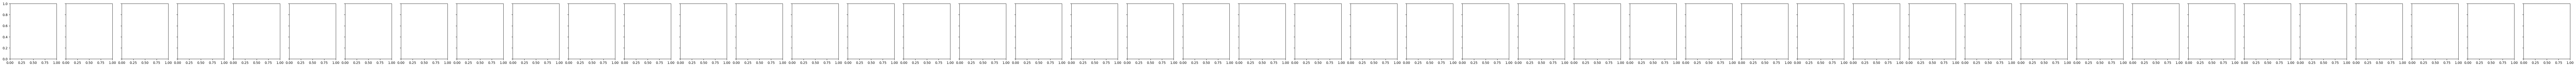

2023-08-15 11:32:42,417 - distributed.nanny - WARNING - Worker process still alive after 3.1999975585937506 seconds, killing
2023-08-15 11:32:42,419 - distributed.nanny - WARNING - Worker process still alive after 3.1999987792968754 seconds, killing
2023-08-15 11:32:42,421 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2023-08-15 11:32:42,423 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2023-08-15 11:32:42,424 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2023-08-15 11:32:42,427 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing


In [ ]:
timesteps = []
cplot = (incr_storms.sst.sel(inidate='2022-02-10').mean(dim='number')-pi_storms.sst.sel(inidate='2022-02-10').mean(dim='number')).sortby('timestep').plot.contourf(col='timestep',levels=np.linspace(-5,5,11))


The two/three vertical color stripes are really FUNKYYYYY

Lag analysis of Maximum total precipitation rate since previous post-processing==mxtpr

2023-08-15 11:11:55,257 - distributed.nanny - WARNING - Worker process still alive after 3.1999986267089846 seconds, killing
/tmp/user/27783/ipykernel_501068/3990463339.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('6 days lead')
/tmp/user/27783/ipykernel_501068/3990463339.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('2 days lead')
/tmp/user/27783/ipykernel_501068/3990463339.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27783/ipykernel_501068/3990463339.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].s

Text(29.597222222222214, 0.5, 'lat from storm centre')

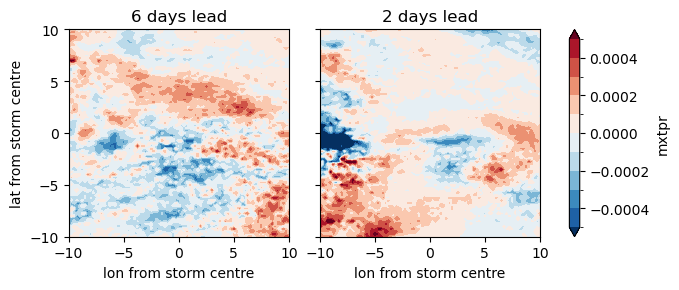


Traceback (most recent call last):
  File "/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/distributed/utils.py", line 803, in wrapper
    return await func(*args, **kwargs)
  File "/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/distributed/worker.py", line 1508, in close
    await self.finished()
  File "/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/distributed/core.py", line 592, in finished
    await self._event_finished.wait()
  File "/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/asyncio/locks.py", line 226, in wait
    await fut
asyncio.exceptions.CancelledError
2023-08-15 11:12:06,253 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-08-15 11:12:06,254 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing


In [ ]:
cplot = (incr_storms.mxtpr.sel(timestep=0).mean('number').squeeze() - pi_storms.mxtpr.sel(timestep=0).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',levels=np.linspace(-0.0005,0.0005,11))

cplot.axes[0,0].set_title('6 days lead')
cplot.axes[0,1].set_title('2 days lead')


cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')

cplot.axes[0,0].set_ylabel('lat from storm centre')

Task exception was never retrieved
future: <Task finished name='Task-855' coro=<Worker.close() done, defined at /home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/distributed/utils.py:801> exception=CommClosedError('in <TCP (closed) ConnectionPool.close_gracefully local=tcp://127.0.0.1:39336 remote=tcp://127.0.0.1:34993>: Stream is closed')>
Traceback (most recent call last):
  File "/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/distributed/utils.py", line 803, in wrapper
    return await func(*args, **kwargs)
  File "/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/si

Text(29.597222222222214, 0.5, 'lat from storm centre')

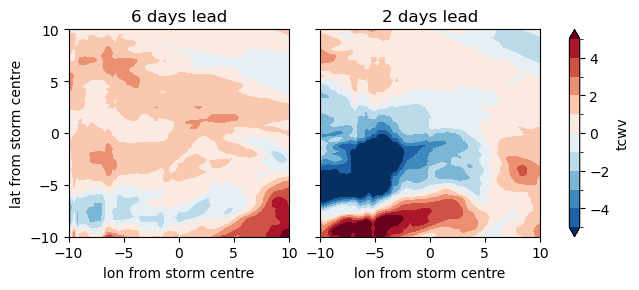

In [ ]:
cplot = (incr_storms.tcwv.sel(timestep=0).mean('number').squeeze() - pi_storms.tcwv.sel(timestep=0).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

cplot.axes[0,0].set_title('6 days lead')
cplot.axes[0,1].set_title('2 days lead')


cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')

cplot.axes[0,0].set_ylabel('lat from storm centre')

In [ ]:
incr_storms.head()

<xarray.Dataset>
Dimensions:       (storm_lon: 5, storm_lat: 5, timestep: 5, number: 5,
                   experiment: 1, inidate: 2)
Coordinates:
  * storm_lon     (storm_lon) float64 -10.0 -9.75 -9.5 -9.25 -9.0
  * storm_lat     (storm_lat) float64 -10.0 -9.75 -9.5 -9.25 -9.0
  * timestep      (timestep) float64 -3.75 -3.5 -3.25 -3.0 -2.75
  * number        (number) int32 2 3 4 5 6
  * experiment    (experiment) object 'incr'
  * inidate       (inidate) datetime64[ns] 2022-02-14 2022-02-10
Data variables: (12/14)
    sst           (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 5, 5), meta=np.ndarray>
    u10           (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 5, 5), meta=np.ndarray>
    v10           (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 5, 5), meta=np.ndarray>
    msl           (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 5, 5), meta=np.ndarray>
    u100          (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 5, 5), meta=np.ndarray>
    v100          (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 5, 5), meta=np.ndarray>
    ...            ...
    ws10          (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 5, 5), meta=np.ndarray>
    ws100         (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 5, 5), meta=np.ndarray>
    mxtpr         (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 5, 5), meta=np.ndarray>
    centroid_lon  (inidate, experiment, number, timestep) float64 nan ... nan
    centroid_lat  (inidate, experiment, number, timestep) float64 nan ... nan
    datetime      (inidate, experiment, number, timestep) datetime64[ns] NaT ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-12-09 04:01:11 GMT by grib_to_netcdf-2.26.0: grib_to_n...